# Deep learning

In [1]:
%load_ext autoreload
%autoreload 2

import tasks.data
import tasks.torch_train_eval
import tasks.adaptive_train_eval
import tasks.calibration

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output"

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"

FINETUNED_MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
ADAPTIVE_MODEL_DIR = os.path.join(OUTPUT_DIR, "adaptive")

FINETUNE_MODEL = False
ADAPT_MODEL = True

RANDOM_SEED = 42
BATCH_SIZE = 3

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import imageio.v2 as imageio
from torchvision.transforms import v2


def resnet_preprocessor(image: np.ndarray) -> np.ndarray:
    """
    Preprocesses an image for ResNet model.

    :param numpy.ndarray image: The input image.
    :return: Preprocessed image.
    :rtype: numpy.ndarray
    """
    preprocess = torchvision.transforms.Compose(
        [    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
            v2.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

    image = preprocess(image)
    return image


def image_read_func(image_path):
    return imageio.imread(image_path, pilmode='RGB')


In [3]:
import random



def train_val_test_split(
    dataset: tasks.data.ImageDataset, val_ratio: float, test_ratio: float
):
    """
    Splits into pure ImageDataset objects, not Subsets, to allow for dynamic changes in the
    underlying data using the custom class API.
    """
    train_ratio = 1 - val_ratio - test_ratio

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)

    # Split the dataset into train, validation, and test sets
    train_dataset = tasks.data.ImageDataset(
        parser_func=dataset.parser_func,
        preprocessing_func=dataset.preprocessing_func,
        label_encoder=dataset.label_encoder,
    )
    val_dataset = tasks.data.ImageDataset(
        parser_func=dataset.parser_func,
        preprocessing_func=dataset.preprocessing_func,
        label_encoder=dataset.label_encoder,
    )
    test_dataset = tasks.data.ImageDataset(
        parser_func=dataset.parser_func,
        preprocessing_func=dataset.preprocessing_func,
        label_encoder=dataset.label_encoder,
    )

    random.shuffle(dataset.samples)
    for idx, sample in enumerate(dataset.samples):
        if idx < train_size:
            train_dataset.add(sample[0], sample[1])
        elif idx < train_size + val_size:
            val_dataset.add(sample[0], sample[1])
        else:
            test_dataset.add(sample[0], sample[1])

    return train_dataset, val_dataset, test_dataset


source_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = train_val_test_split(
    source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [4]:
def create_padded_dataloader(
    dataset: tasks.data.ImageDataset,
    shuffle: bool = True,
):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        collate_fn=tasks.data.collate_pad,
    )


source_train_loader = create_padded_dataloader(source_train_dataset, shuffle=True)
source_val_loader = create_padded_dataloader(source_val_dataset, shuffle=False)
source_test_loader = create_padded_dataloader(source_test_dataset, shuffle=False)

In [5]:
import pickle


def try_load_weights(model, weights_path: str):
    try:
        model.load_state_dict(torch.load(weights_path))
    except Exception as e:
        print("Cannot load proper weights: ", e)
    return model


def try_load_history(history_path):
    try:
        with open(history_path, 'rb') as handle:
            history = pickle.load(handle)
    except:
        print("No history found in path ", history_path)
        history = None

    return history

In [6]:
import torchinfo


model = torch.hub.load(
    "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
).to(device)
model = try_load_weights(model, os.path.join(FINETUNED_MODEL_DIR, "model.pt"))

torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Cannot load proper weights:  [Errno 2] No such file or directory: 'output/classifier/model.pt'


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [3, 1000]                 --
├─Conv2d: 1-1                            [3, 64, 150, 150]         9,408
├─BatchNorm2d: 1-2                       [3, 64, 150, 150]         128
├─ReLU: 1-3                              [3, 64, 150, 150]         --
├─MaxPool2d: 1-4                         [3, 64, 75, 75]           --
├─Sequential: 1-5                        [3, 64, 75, 75]           --
│    └─BasicBlock: 2-1                   [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-2             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-3                    [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-5             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-6                    [3, 64, 75, 75]           --
│

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)
# disable lr for adam
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.05)
previous_history = try_load_history(os.path.join(FINETUNED_MODEL_DIR, "history.pickle"))


if FINETUNE_MODEL:
    model, history = tasks.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=FINETUNED_MODEL_DIR,
        num_epochs=50,
        patience=10,
        warmup_period=25,
        previous_history=previous_history
    )
else:
    history = previous_history

No history found in path  output/classifier/history.pickle
Epoch 0/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 3.9709 Train Acc: 0.1439
Val Loss: 3.6070 Val Acc: 0.2464
Epoch 1/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 3.3639 Train Acc: 0.2623
Val Loss: 3.9256 Val Acc: 0.3412
Epoch 2/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 2.9541 Train Acc: 0.3835
Val Loss: 3.9823 Val Acc: 0.4384
Epoch 3/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 2.6896 Train Acc: 0.4787
Val Loss: 3.1819 Val Acc: 0.5948
Epoch 4/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 2.3875 Train Acc: 0.5961
Val Loss: 2.8100 Val Acc: 0.6469
Epoch 5/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 2.2157 Train Acc: 0.6558
Val Loss: 2.8558 Val Acc: 0.6493
Epoch 6/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 2.0329 Train Acc: 0.7202
Val Loss: 2.9545 Val Acc: 0.6825
Epoch 7/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.9057 Train Acc: 0.7647
Val Loss: 2.8762 Val Acc: 0.7417
Epoch 8/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.7606 Train Acc: 0.8026
Val Loss: 2.9247 Val Acc: 0.6611
Epoch 9/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.6839 Train Acc: 0.8381
Val Loss: 2.7720 Val Acc: 0.6777
Epoch 10/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.5748 Train Acc: 0.8812
Val Loss: 2.7213 Val Acc: 0.7559
Epoch 11/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.5256 Train Acc: 0.8873
Val Loss: 3.0985 Val Acc: 0.7630
Epoch 12/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.4874 Train Acc: 0.9006
Val Loss: 2.8584 Val Acc: 0.8104
Epoch 13/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.4076 Train Acc: 0.9266
Val Loss: 2.4443 Val Acc: 0.7844
Epoch 14/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.3943 Train Acc: 0.9356
Val Loss: 2.6309 Val Acc: 0.7986
Epoch 15/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.3474 Train Acc: 0.9508
Val Loss: 2.4562 Val Acc: 0.8199
Epoch 16/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.3282 Train Acc: 0.9531
Val Loss: 2.3121 Val Acc: 0.7630
Epoch 17/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.3024 Train Acc: 0.9583
Val Loss: 2.5766 Val Acc: 0.7536
Epoch 18/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.2571 Train Acc: 0.9706
Val Loss: 2.3068 Val Acc: 0.7322
Epoch 19/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.2613 Train Acc: 0.9730
Val Loss: 2.3747 Val Acc: 0.7156
Epoch 20/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1973 Train Acc: 0.9863
Val Loss: 2.2553 Val Acc: 0.7488
Epoch 21/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.2396 Train Acc: 0.9777
Val Loss: 2.5135 Val Acc: 0.8081
Epoch 22/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.2306 Train Acc: 0.9759
Val Loss: 2.4377 Val Acc: 0.6209
Epoch 23/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.2153 Train Acc: 0.9796
Val Loss: 2.3018 Val Acc: 0.7701
Epoch 24/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1968 Train Acc: 0.9863
Val Loss: 2.3383 Val Acc: 0.7464
Epoch 25/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.2075 Train Acc: 0.9830
Val Loss: 2.4018 Val Acc: 0.7346
Epoch 26/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1961 Train Acc: 0.9848
Val Loss: 2.1975 Val Acc: 0.7299
Epoch 27/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1685 Train Acc: 0.9896
Val Loss: 2.2927 Val Acc: 0.7275
Epoch 28/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1927 Train Acc: 0.9853
Val Loss: 2.4464 Val Acc: 0.7583
Epoch 29/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1571 Train Acc: 0.9924
Val Loss: 2.2619 Val Acc: 0.7464
Epoch 30/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1592 Train Acc: 0.9867
Val Loss: 2.1440 Val Acc: 0.7867
Epoch 31/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1447 Train Acc: 0.9948
Val Loss: 2.2399 Val Acc: 0.6872
Epoch 32/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1661 Train Acc: 0.9872
Val Loss: 2.8303 Val Acc: 0.7109
Epoch 33/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1506 Train Acc: 0.9910
Val Loss: 2.1682 Val Acc: 0.8318
Epoch 34/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1215 Train Acc: 0.9943
Val Loss: 2.1783 Val Acc: 0.7749
Epoch 35/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1419 Train Acc: 0.9943
Val Loss: 2.3222 Val Acc: 0.6991
Epoch 36/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1340 Train Acc: 0.9943
Val Loss: 2.2529 Val Acc: 0.7678
Epoch 37/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1115 Train Acc: 0.9972
Val Loss: 2.0492 Val Acc: 0.7844
Epoch 38/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1155 Train Acc: 0.9938
Val Loss: 2.2019 Val Acc: 0.7417
Epoch 39/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1135 Train Acc: 0.9967
Val Loss: 2.2504 Val Acc: 0.7322
Epoch 40/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1037 Train Acc: 0.9976
Val Loss: 2.3740 Val Acc: 0.6706
Epoch 41/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1069 Train Acc: 0.9976
Val Loss: 2.1966 Val Acc: 0.7607
Epoch 42/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1096 Train Acc: 0.9972
Val Loss: 2.3022 Val Acc: 0.8057
Epoch 43/49
----------


  0%|          | 0/704 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Train Loss: 1.1064 Train Acc: 0.9976
Val Loss: 2.3021 Val Acc: 0.7891
Training complete in 489m 43s
Best val Acc: 0.831754


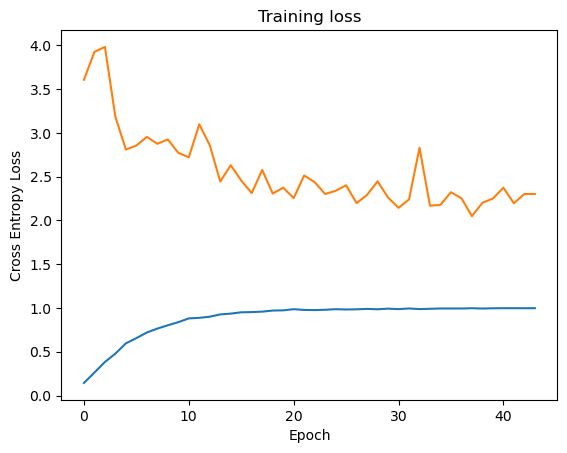

In [8]:
plt.plot(np.array(range(len(history["train_loss"]))), history["train_loss"])
plt.plot(np.array(range(len(history["val_loss"]))), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training loss")
plt.show()

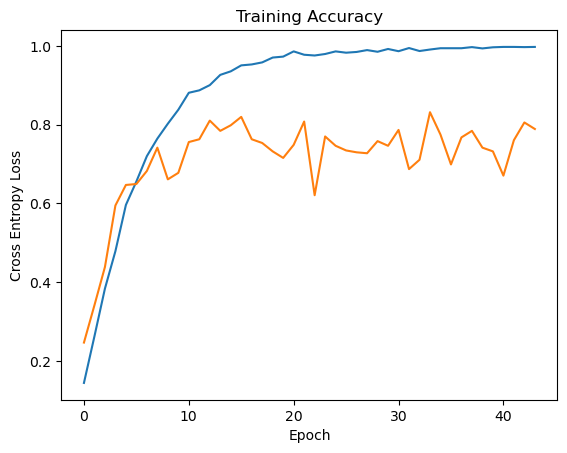

In [9]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [10]:
# save logits for later calibration
source_actual, source_predicted = tasks.torch_train_eval.test(
    model, source_test_loader, device
)
class_names = source_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        source_actual,
        source_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/95 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.78      1.00      0.88         7
            bike       1.00      1.00      1.00         5
     bike_helmet       1.00      1.00      1.00         7
        bookcase       0.78      1.00      0.88         7
          bottle       0.40      0.50      0.44         4
      calculator       0.80      1.00      0.89         8
      desk_chair       1.00      1.00      1.00        10
       desk_lamp       0.88      0.88      0.88         8
desktop_computer       0.86      0.46      0.60        13
    file_cabinet       1.00      0.50      0.67        10
      headphones       1.00      0.60      0.75         5
        keyboard       0.87      0.76      0.81        17
 laptop_computer       1.00      0.92      0.96        13
     letter_tray       1.00      0.50      0.67         6
    mobile_phone       1.00      0.78      0.88         9
         monitor       1.00      0.89      0.94         9
           mo

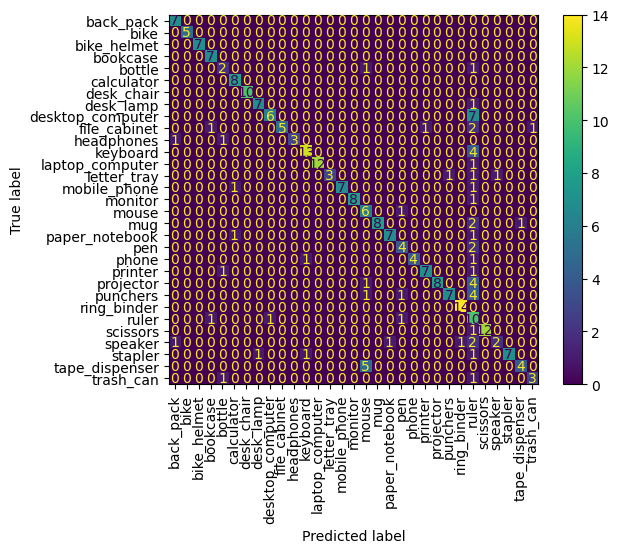

In [11]:
source_cf_matrix = sklearn.metrics.confusion_matrix(source_actual, source_predicted)
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=source_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

In [12]:
target_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
    label_encoder=source_dataset.label_encoder # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = train_val_test_split(
    target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
)

target_train_loader = create_padded_dataloader(target_train_dataset, shuffle=True)
target_test_loader = create_padded_dataloader(target_test_dataset, shuffle=False)

  0%|          | 0/31 [00:00<?, ?it/s]

In [13]:
target_actual, target_predicted = tasks.torch_train_eval.test(model, target_test_loader, device)
class_names = target_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        target_actual,
        target_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/40 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.67      0.40      0.50         5
            bike       1.00      0.50      0.67         2
     bike_helmet       0.75      0.75      0.75         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       1.00      0.50      0.67         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       1.00      0.67      0.80         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

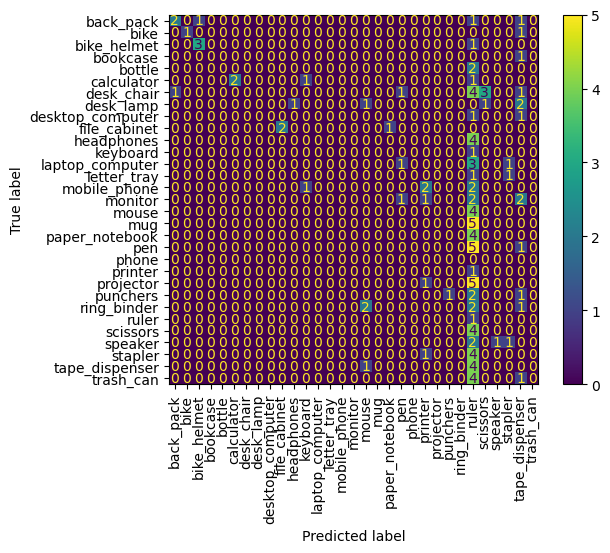

In [16]:
target_cf_matrix = sklearn.metrics.confusion_matrix(target_actual, target_predicted, labels=np.arange(0, len(class_names), 1))
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=target_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

## Domain Adaptation

In [ ]:
unlabeled_dataset = tasks.data.UnlabeledImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
unlabeled_dataset.load_from_image_dataset(target_train_dataset)

source_history = try_load_history(os.path.join(ADAPTIVE_MODEL_DIR, "source_history.pickle"))
target_history = try_load_history(os.path.join(ADAPTIVE_MODEL_DIR, "target_history.pickle"))

In [ ]:
if ADAPT_MODEL:
    tasks.adaptive_train_eval.train_adaptive_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        source_train_dataset=source_train_dataset,
        source_val_dataset=source_val_dataset,
        source_dataloader_initializer=lambda dataset: create_padded_dataloader(
            dataset, shuffle=True
        ),
        target_train_dataset=unlabeled_dataset,
        target_val_dataset=target_val_dataset,
        output_dir=ADAPTIVE_MODEL_DIR,
        num_epochs=20,
        previous_source_history=source_history,
        previous_target_history=target_history,
    )

## Dustbin